In [12]:
from backtesting.test import SMA
import os
from binance.client import Client
import pandas as pd
import btalib
import numpy as np

In [13]:
# Binance API
api_key = os.environ.get('binance_api')
api_secret = os.environ.get('binance_secret')

In [14]:
client = Client(api_key, api_secret)

In [15]:
# from optparse import Values


def EMA(values, n):
    """
    Return exp moving average of `values`, at
    each step taking into account `n` previous values.
    """
    
    # return btalib.ema(Values, period=n)
    
    # return pd.Series(values).rolling(n).mean()
    return pd.Series(values).ewm(span=n, adjust=False).mean()


In [16]:
def SMA(values, n):
    """
    Return exp moving average of `values`, at
    each step taking into account `n` previous values.
    """
        
    return pd.Series(values).rolling(n).mean()
    

In [17]:
def bollinger_bands(df, length=20, m=2):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(length, min_periods=length).mean()), name='B_MA')
    sigma = data.rolling(length, min_periods=length).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [30]:
from backtesting import Strategy
from backtesting.lib import crossover


# we will use four moving averages in total: 
# two moving averages whose relationship determines a general trend (we only trade long when the shorter MA is above the longer one, and vice versa), 
# and two moving averages whose cross-over with daily close prices determine the signal to enter or exit the position.
class Sma4Cross(Strategy):
    n1 = 10
    n2 = 64
    # n_enter = 20
    # n_exit = 10
    
    def init(self):
        # self.sma1 = self.I(EMA, self.data.Close, self.n1)
        # self.sma2 = self.I(EMA, self.data.Close, self.n2)
        
        self.sma1 = self.I(EMA, self.data.Close, self.n1)
        self.sma2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):

        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

        # -----------------------
        
        """ if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                # if crossover(self.data.Close, self.sma_enter):
                self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                # if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long): 
            # and
            #     crossover(self.sma_exit, self.data.Close)
            #     or
            #     self.position.is_short and
            #     crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()
         """

In [25]:
import datetime as dt

def getdata(Symbol):
    frame = pd.DataFrame(client.get_historical_klines(Symbol,
                                                      client.KLINE_INTERVAL_1DAY,
                                                    #   '3 years ago UTC')
                                                      '1 Feb, 2019 UTC', # bear market anterior
                                                      # '16 Nov, 2021 UTC' # inicio bear market 
                                                      # '14 Jun, 2022 UTC'   # 20k suporte 
                                                      # '90 day ago UTC'
                                                      # '4000 hour ago UTC' # 4hour
                                                      ))
    
    frame = frame.iloc[:,:6] # use the first 5 columns
    frame.columns = ['Time','Open','High','Low','Close','Volume'] #rename columns
    frame[['Open','High','Low','Close','Volume']] = frame[['Open','High','Low','Close','Volume']].astype(float) #cast to float
    # frame.Time = pd.to_datetime(frame.Time, unit='ms') #make human readable timestamp
    frame.index = [dt.datetime.fromtimestamp(x/1000.0) for x in frame.Time]
    return frame

In [31]:
%%time 

from backtesting import Backtest

# GOOG = Open	High	Low	Close	Volume
df = getdata('BTCUSDT')
df = df.drop(['Time'], axis=1)
# df
# df = bollinger_bands(df)


bt = Backtest(df, Sma4Cross, cash=100000, commission=0.001)
stats = bt.run()
stats
# bt.plot() 


CPU times: user 585 ms, sys: 35.8 ms, total: 621 ms
Wall time: 2.11 s


Start                     2019-02-01 00:00:00
End                       2022-10-29 01:00:00
Duration                   1366 days 01:00:00
Exposure Time [%]                   99.561083
Equity Final [$]                   2919391.03
Equity Peak [$]                    3023784.55
Return [%]                         2819.39103
Buy & Hold Return [%]              505.185915
Return (Ann.) [%]                  146.175499
Volatility (Ann.) [%]              167.404022
Sharpe Ratio                          0.87319
Sortino Ratio                        3.846512
Calmar Ratio                         4.170453
Max. Drawdown [%]                   -35.05027
Avg. Drawdown [%]                    -8.30636
Max. Drawdown Duration      260 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                   25
Win Rate [%]                             48.0
Best Trade [%]                     356.221077
Worst Trade [%]                    -11.268967
Avg. Trade [%]                    

In [32]:
bt.plot() 

/tmp/ipykernel_20623/1595428651.py:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


Row(id='4469', ...)

Gtk-Message: 18:52:00.615: Failed to load module "appmenu-gtk-module"
Gtk-Message: 18:52:00.704: Failed to load module "canberra-gtk-module"
Gtk-Message: 18:52:00.705: Failed to load module "canberra-gtk-module"
Gtk-Message: 18:52:04.467: Failed to load module "appmenu-gtk-module"
Gtk-Message: 18:52:04.558: Failed to load module "canberra-gtk-module"
Gtk-Message: 18:52:04.559: Failed to load module "canberra-gtk-module"


Opening in existing browser session.


In [28]:
stats, heatmap = bt.optimize(
    n1=range(8, 50, 2),
    n2=range(8, 100, 2),
    # n_enter=range(15, 35, 5),
    # n_exit=range(10, 25, 5),
    # constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    constraint=lambda param: param.n1 < param.n2,
    maximize='Equity Final [$]',
    # max_tries=200,
    # random_state=0,
    return_heatmap=True)

/home/joaosilva/.local/lib/python3.10/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 966 configurations.
  output = _optimize_grid()


In [29]:
heatmap.dropna(inplace=True)
# heatmap.droplevel
# drop(labels inplace=True)
# heatmap = heatmap[heatmap[0] > heatmap[1]]
heatmap.sort_values().iloc[-20:]
# print(heatmap)

n1  n2
14  56    2388329.95
8   66    2395638.14
12  54    2401971.43
26  34    2420453.61
20  44    2437881.71
18  54    2462462.29
28  32    2467538.76
20  42    2501899.90
18  48    2504438.37
16  52    2512550.38
18  46    2541357.70
14  54    2552980.37
8   64    2567089.59
10  66    2623843.84
12  62    2719430.64
    58    2769126.04
    60    2801103.93
14  58    2854382.78
16  56    2903061.87
10  64    2919391.03
Name: Equity Final [$], dtype: float64

In [ ]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,8,10,12,14,16,18,20,22,24,26,...,80,82,84,86,88,90,92,94,96,98
n1,,,,,,,,,,,,,,,,,,,,,
8,NaN,76602.94,77322.34,90689.74,92663.78,92663.78,81697.59,81697.59,81896.15,79687.65,...,84789.24,84789.24,84789.24,84789.24,84789.24,84789.24,84789.24,84789.24,84789.24,84789.24
10,127449.51,NaN,92663.78,92663.78,92533.58,81697.59,81896.15,78395.91,97317.32,94995.08,...,85174.32,85174.32,85174.32,85174.32,85174.32,85174.32,85174.32,85174.32,85174.32,85174.32
12,131940.03,132838.33,NaN,79086.95,82373.83,81896.15,87045.70,99874.96,94995.08,94995.08,...,93465.38,93465.38,93465.38,93465.38,93465.38,93465.38,93465.38,93465.38,93465.38,93465.38
14,132838.33,132838.33,132838.33,NaN,81896.15,97317.32,94995.08,94995.08,94995.08,94995.08,...,93465.38,93465.38,93465.38,88185.78,88185.78,88185.78,88185.78,88185.78,88185.78,88185.78
16,132838.33,132838.33,111005.13,127505.53,NaN,94995.08,94995.08,94995.08,94995.08,94995.08,...,88185.78,88185.78,85572.70,85572.70,85572.70,85572.70,85572.70,85572.70,85572.70,85572.70
18,120371.05,116107.11,127505.53,126906.30,121226.14,NaN,94995.08,94995.08,94995.08,94531.28,...,85572.70,85572.70,85572.70,85572.70,85572.70,85572.70,85572.70,85572.70,85572.70,84766.54
20,116107.11,127505.53,118942.84,121226.14,121226.14,106067.49,NaN,94995.08,82679.72,84789.24,...,84766.54,84766.54,84766.54,84766.54,87284.09,87284.09,87284.09,87284.09,87284.09,87284.09
22,122449.09,114677.03,117763.19,121226.14,106067.49,106067.49,106067.49,NaN,84789.24,85174.32,...,87284.09,87284.09,87284.09,87284.09,87284.09,87284.09,87284.09,87284.09,86835.14,86835.14
24,110437.28,126906.30,121226.14,121226.14,106067.49,106067.49,124865.08,124865.08,NaN,84970.80,...,87284.09,87284.09,86835.14,86835.14,86835.14,86835.14,86835.14,86835.14,86835.14,86835.14


<AxesSubplot:xlabel='n2', ylabel='n1'>

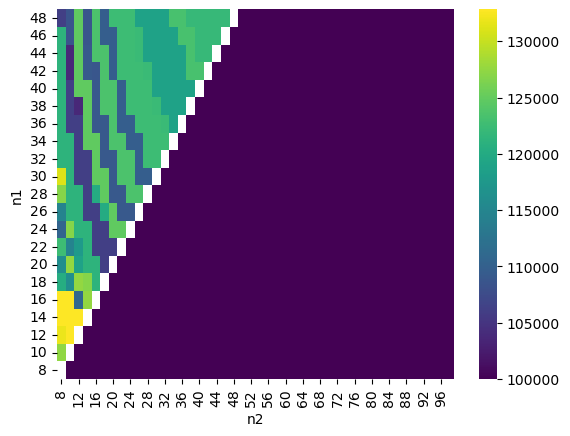

In [ ]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis',vmin=100000)

In [ ]:
import matplotlib.pyplot as plt

# GOOG = Open	High	Low	Close	Volume
coinPair = 'MATICUSDT'
df = getdata(coinPair)
df = df.drop(['Time'], axis=1)
df = bollinger_bands(df)

# df = bollinger_bands(df)
# df.plot(df.Close)
# df.plot.title('Price Close')
# plt.show()


In [ ]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Close'])
plt.title('Price chart (Adj Close) ' + str(coinPair))
plt.show()


In [ ]:

# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(coinPair))
plt.plot(df.index, df['Close'])
plt.plot(df.index, df['BU'], alpha=0.3)
plt.plot(df.index, df['BL'], alpha=0.3)
plt.plot(df.index, df['B_MA'], alpha=0.3)
plt.fill_between(df.index, df['BU'], df['BL'], color='grey', alpha=0.1)

plt.show()